In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import transformers
from transformers import LayoutLMv2Processor, LayoutLMForTokenClassification, AdamW, BertForTokenClassification,\
    BertTokenizer, LayoutLMTokenizer, AutoTokenizer
from datasets import load_dataset
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import logging
from torch.utils.data import DataLoader
from torcheval.metrics.functional import multiclass_f1_score, multiclass_confusion_matrix
from copy import deepcopy

import os 
while 'notebooks' in os.getcwd():
    os.chdir("..")
    
from src.preprocessing.make_dataset import ImageLayoutDataset
from src.model.trainer import BertTrainer, LayoutLMTrainer
import warnings
warnings.filterwarnings("ignore")

In [3]:
!mkdir logs

mkdir: cannot create directory ‘logs’: File exists


In [4]:
model_name = "few_shot_learning"
dataset_name = "funsd"

In [5]:
logging.basicConfig(filename='logs/few_shot_learning_cord.log', encoding='utf-8', level= logging.INFO)

## Obtaining data

In [6]:
dataset = load_dataset("nielsr/funsd")

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image_path'],
        num_rows: 149
    })
    test: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image_path'],
        num_rows: 50
    })
})

In [8]:
dataset['train'].features['ner_tags'].feature.names

['O',
 'B-HEADER',
 'I-HEADER',
 'B-QUESTION',
 'I-QUESTION',
 'B-ANSWER',
 'I-ANSWER']

In [9]:
n_classes = len(dataset['train'].features['ner_tags'].feature.names)
n_classes

7

In [10]:
bert_tokenizer =AutoTokenizer.from_pretrained("bert-base-uncased")

In [11]:
llm_tokenizer = AutoTokenizer.from_pretrained("microsoft/layoutlm-base-uncased",)

## BERT

In [12]:
train_dataset = ImageLayoutDataset(
    dataset['train'], 
    tokenizer=bert_tokenizer
)

 13%|█▎        | 20/149 [00:00<00:01, 91.68it/s]

100%|██████████| 149/149 [00:01<00:00, 127.92it/s]


In [13]:
validation_dataset = ImageLayoutDataset(
    dataset['test'],
    tokenizer= bert_tokenizer
)

 22%|██▏       | 11/50 [00:00<00:00, 109.36it/s]

100%|██████████| 50/50 [00:00<00:00, 106.79it/s]


In [16]:
device = "cuda"

In [18]:
n = len(train_dataset)
history= {}

validation_dataloader = DataLoader(
    validation_dataset,
    batch_size=1, #model applied to every point
    shuffle = False
)

for i in range(7):
    num_samples = n//2**i #part of the training dataset used

    train_dataloader = DataLoader(
        train_dataset[0: num_samples],
        batch_size=2, #model applied to 1 in every 2 points
        shuffle = False
    )

    bert = BertForTokenClassification\
        .from_pretrained(
            'bert-base-uncased', 
            num_labels = n_classes #possible outputs
        )
    
    bert.to(device)

    trainer = BertTrainer(
        bert
    )

    print(f"training {trainer.model_name} with {num_samples} samples")

    trainer.compile(
        train_dataloader,
        validation_dataloader,
        n_classes= n_classes,
        device = "cuda"
    )

    history[num_samples] = trainer.history

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


training bert with 149 samples


100%|██████████| 10/10 [00:52<00:00,  5.27s/it]
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


training bert with 74 samples


100%|██████████| 10/10 [00:27<00:00,  2.77s/it]
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


training bert with 37 samples


100%|██████████| 10/10 [00:16<00:00,  1.62s/it]
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


training bert with 18 samples


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


training bert with 9 samples


100%|██████████| 10/10 [00:07<00:00,  1.28it/s]
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


training bert with 4 samples


100%|██████████| 10/10 [00:06<00:00,  1.53it/s]
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


training bert with 2 samples


100%|██████████| 10/10 [00:06<00:00,  1.66it/s]


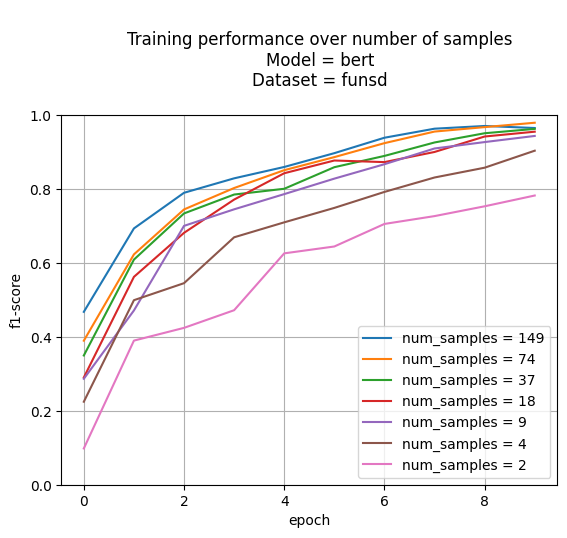

In [19]:
for k in history.keys():
    data = history[k]['train-f1']
    plt.plot(
        data,
        label = f"num_samples = {k}"
    )

plt.title(f'''
    Training performance over number of samples
    Model = {trainer.model_name}
    Dataset = {dataset_name}
''')

plt.xlabel("epoch")
plt.ylabel("f1-score")
plt.ylim([0,1])
plt.grid()
plt.legend()
plt.show()

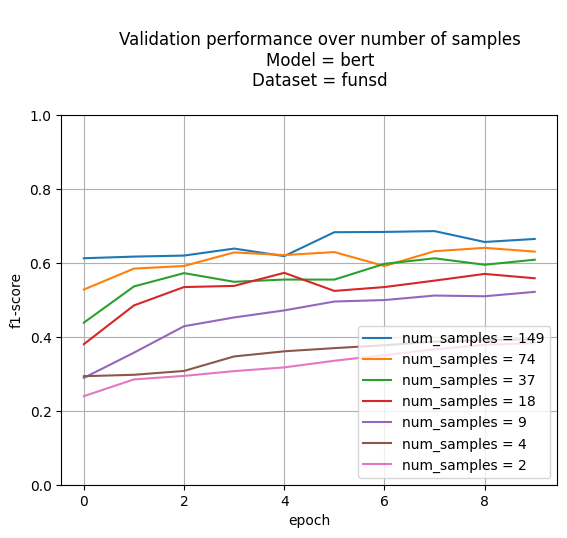

In [20]:
for k in history.keys():
    data = history[k]['validation-f1']
    plt.plot(
        data,
        label = f"num_samples = {k}"
    )

plt.title(f'''
    Validation performance over number of samples
    Model = {trainer.model_name}
    Dataset = {dataset_name}
''')

plt.xlabel("epoch")
plt.ylabel("f1-score")
plt.ylim([0,1])
plt.grid()
plt.legend()
plt.show()

## LayoutLM

In [12]:
train_dataset = ImageLayoutDataset(
    dataset['train'], 
    tokenizer=llm_tokenizer
)

  0%|          | 0/149 [00:00<?, ?it/s]

100%|██████████| 149/149 [00:01<00:00, 98.54it/s] 


In [15]:
test_dataset = ImageLayoutDataset(
    dataset['test'],
    tokenizer= llm_tokenizer
)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:00<00:00, 94.80it/s] 


In [14]:
device = "cuda"

In [16]:
n = len(train_dataset)
history= {}
test = {}



for i in [2,5,10, 100]:
    num_samples = i

    train_dataloader = DataLoader(
        train_dataset[0: num_samples],
        batch_size=1,
        shuffle = False
    )

    validation_dataloader = DataLoader(
        train_dataset[num_samples:],
        batch_size=1,
        shuffle = False
    )

    layoutlm = LayoutLMForTokenClassification\
        .from_pretrained(
            'microsoft/layoutlm-base-uncased', 
            num_labels = n_classes,
            cache_dir = "/Data/pedro.silva/"
        )
    
    layoutlm.to(device)

    trainer = LayoutLMTrainer(
        layoutlm
    )

    print(f"training {trainer.model_name} with {num_samples} samples")

    trainer.compile(
        train_dataloader,
        validation_dataloader,
        n_classes= n_classes,
        device = "cuda"
    )

    test_dataloader = DataLoader(
        test_dataset,
        batch_size = 1
    )
    f1, conf_matrix = trainer.evaluate(
        test_dataloader,
        n_classes= n_classes
    )

    history[num_samples] = trainer.history

    test[num_samples]={

        'f1': f1,
        'confusion_matrix': conf_matrix
    }

    history[num_samples] = trainer.history

f1: 0.3093259930610657


100%|██████████| 2/2 [00:00<00:00, 21.62it/s]


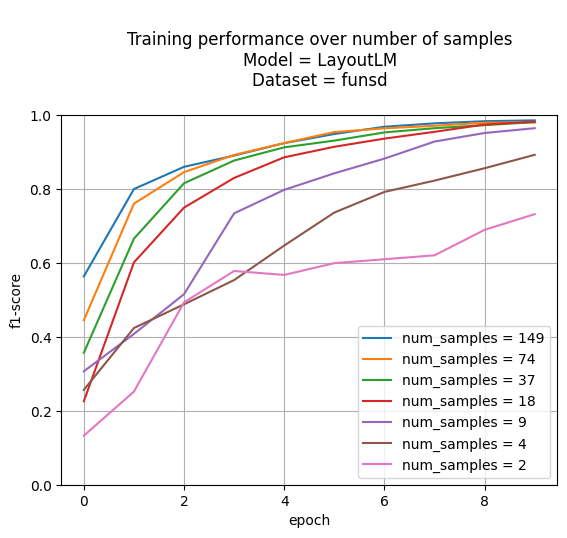

In [30]:
for k in history.keys():
    data = history[k]['train-f1']
    plt.plot(
        data,
        label = f"num_samples = {k}"
    )

plt.title(f'''
    Training performance over number of samples
    Model = {trainer.model_name}
    Dataset = {dataset_name}
''')

plt.xlabel("epoch")
plt.ylabel("f1-score")
plt.ylim([0,1])
plt.grid()
plt.legend()
plt.show()

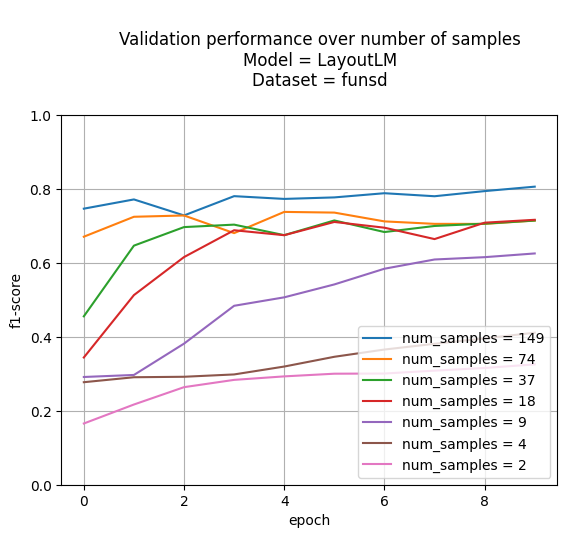

In [31]:
for k in history_layoutlm.keys():
    data = history_layoutlm[k]['validation-f1']
    plt.plot(
        data,
        label = f"num_samples = {k}"
    )

plt.title(f'''
    Validation performance over number of samples
    Model = {trainer.model_name}
    Dataset = {dataset_name}
''')

plt.xlabel("epoch")
plt.ylabel("f1-score")
plt.ylim([0,1])
plt.grid()
plt.legend()
plt.show()

In [16]:
num_samples = 10

In [17]:
validation_dataloader = DataLoader(
    validation_dataset,
    batch_size=1, #model applied to every point
    shuffle = False
)


In [18]:
device = "cuda"
train_dataloader = DataLoader(
        train_dataset[0: num_samples],
        batch_size=2,
        shuffle = False
    )

layoutlm = LayoutLMForTokenClassification\
    .from_pretrained(
        'microsoft/layoutlm-base-uncased', 
        num_labels = n_classes
    )

layoutlm.to(device)

trainer = LayoutLMTrainer(
    layoutlm
)

print(f"training {trainer.model_name} with {num_samples} samples")

trainer.compile(
    train_dataloader,
    validation_dataloader,
    n_classes= n_classes,
    device = "cuda"
)



Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlm-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


training layoutlm v1 with 10 samples


100%|██████████| 10/10 [00:08<00:00,  1.13it/s]


In [20]:
y_pred_val, y_true_val = trainer.evaluate(
    validation_dataloader
)

In [23]:
multiclass_f1_score(
    y_pred_val,
    y_true_val,
    num_classes = n_classes
)

tensor(0.6966, device='cuda:0')

In [22]:
multiclass_confusion_matrix(
    y_pred_val.to(torch.int64),
    y_true_val.to(torch.int64),
    num_classes= n_classes
)

tensor([[1636,    3,   40,   62,  157,   92,  366],
        [  10,   11,   17,   77,    2,    2,    0],
        [  41,    0,  122,   11,   49,    7,   25],
        [  27,    4,    6,  751,   74,  187,   16],
        [ 203,    1,   21,   50,  776,   27,  399],
        [  19,    0,    0,   57,    7,  671,   55],
        [ 270,    0,    9,   15,   69,  122, 2000]], device='cuda:0')

## Finetuning results 

In [21]:
train_dataset = ImageLayoutDataset(
    dataset['train'], 
    tokenizer=llm_tokenizer
)
validation_dataset = ImageLayoutDataset(
    dataset['test'],
    tokenizer= llm_tokenizer
)
device = "cuda"
n = len(train_dataset)
history_layoutlm= {}

validation_dataloader = DataLoader(
    validation_dataset,
    batch_size=1,
    shuffle = False
)

experiments = [2,5,10]

for num_samples in experiments:
    train_dataloader = DataLoader(
        train_dataset[0: num_samples],
        batch_size=2,
        shuffle = False
    )

    layoutlm = LayoutLMForTokenClassification\
        .from_pretrained(
            'microsoft/layoutlm-base-uncased', 
            num_labels = n_classes
        )
    
    layoutlm.to(device)

    trainer = LayoutLMTrainer(
        layoutlm
    )

    print(f"training {trainer.model_name} with {num_samples} samples")

    trainer.compile(
        train_dataloader,
        validation_dataloader,
        n_classes= n_classes,
        device = "cuda"
    )

    history_layoutlm[num_samples] = trainer.history

  0%|          | 0/149 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:00<00:00, 270.54it/s]
Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlm-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


training layoutlm v1 with 2 samples


100%|██████████| 1/1 [00:00<00:00, 10.10it/s]
Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlm-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


training layoutlm v1 with 5 samples


100%|██████████| 3/3 [00:00<00:00, 13.66it/s]
Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlm-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


training layoutlm v1 with 10 samples


100%|██████████| 5/5 [00:00<00:00,  9.29it/s]


In [22]:
history_layoutlm

{2: {'train_accuracy': [],
  'train-f1': [0.11405835300683975,
   0.2493368685245514,
   0.5278514623641968,
   0.6021220088005066,
   0.6259946823120117,
   0.6286472082138062,
   0.663129985332489,
   0.6870026588439941,
   0.7135278582572937,
   0.7400530576705933],
  'validation-accuracy': [],
  'validation-f1': [0.19495680928230286,
   0.23301424086093903,
   0.26710250973701477,
   0.2888162434101105,
   0.2974550426006317,
   0.30469298362731934,
   0.30667755007743835,
   0.3162502944469452,
   0.3205696940422058,
   0.32979220151901245]},
 5: {'train_accuracy': [],
  'train-f1': [0.2231520265340805,
   0.5202231407165527,
   0.5620641708374023,
   0.6150627732276917,
   0.6903765797615051,
   0.7266387939453125,
   0.7642956972122192,
   0.8131101727485657,
   0.8688982129096985,
   0.892608106136322],
  'validation-accuracy': [],
  'validation-f1': [0.24585570394992828,
   0.2786598205566406,
   0.28659817576408386,
   0.2906841039657593,
   0.3121643662452698,
   0.333527892

In [25]:
for k in history_layoutlm.keys():
    print(f"{k} shots -- f1 :  {np.max(history_layoutlm[k]['validation-f1'])}")

2 shots -- f1 :  0.32979220151901245
5 shots -- f1 :  0.404856413602829
10 shots -- f1 :  0.6755778789520264
